In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('covid_19_data.csv')

# Перевірка даних
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
306424,306425,05/29/2021,Zaporizhia Oblast,Ukraine,2021-05-30 04:20:55,102641.0,2335.0,95289.0
306425,306426,05/29/2021,Zeeland,Netherlands,2021-05-30 04:20:55,29147.0,245.0,0.0
306426,306427,05/29/2021,Zhejiang,Mainland China,2021-05-30 04:20:55,1364.0,1.0,1324.0
306427,306428,05/29/2021,Zhytomyr Oblast,Ukraine,2021-05-30 04:20:55,87550.0,1738.0,83790.0


In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Завантаження даних
df = pd.read_csv('covid_19_data.csv')

# Перетворення дати в формат datetime
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], format='%m/%d/%Y')

# Фільтрація даних по країні (наприклад, Україна)
country = 'Armenia'  # Заміни на бажану країну
df_country = df[df['Country/Region'] == country]

# Перегляд перших кількох рядків для перевірки
df_country.head(25)

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
2990,2991,2020-03-01,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
3123,3124,2020-03-02,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
3274,3275,2020-03-03,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
3435,3436,2020-03-04,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
3608,3609,2020-03-05,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
3795,3796,2020-03-06,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
4011,4012,2020-03-07,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
4260,4261,2020-03-08,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
4527,4528,2020-03-09,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0
4776,4777,2020-03-10,NaN,Armenia,2020-03-01T19:53:02,1.0,0.0,0.0


In [24]:
# Групування за датами та підрахунок загальних значень
df_country_daily = df_country.groupby('ObservationDate').agg({
    'Confirmed': 'sum',
    'Deaths': 'sum',
    'Recovered': 'sum'
}).reset_index()

# Перевірка результату
df_country_daily.head(-1)

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-03-01,1.0,0.0,0.0
1,2020-03-02,1.0,0.0,0.0
2,2020-03-03,1.0,0.0,0.0
3,2020-03-04,1.0,0.0,0.0
4,2020-03-05,1.0,0.0,0.0
...,...,...,...,...
449,2021-05-24,221982.0,4394.0,211375.0
450,2021-05-25,222139.0,4400.0,211634.0
451,2021-05-26,222269.0,4411.0,211957.0
452,2021-05-27,222409.0,4416.0,212265.0


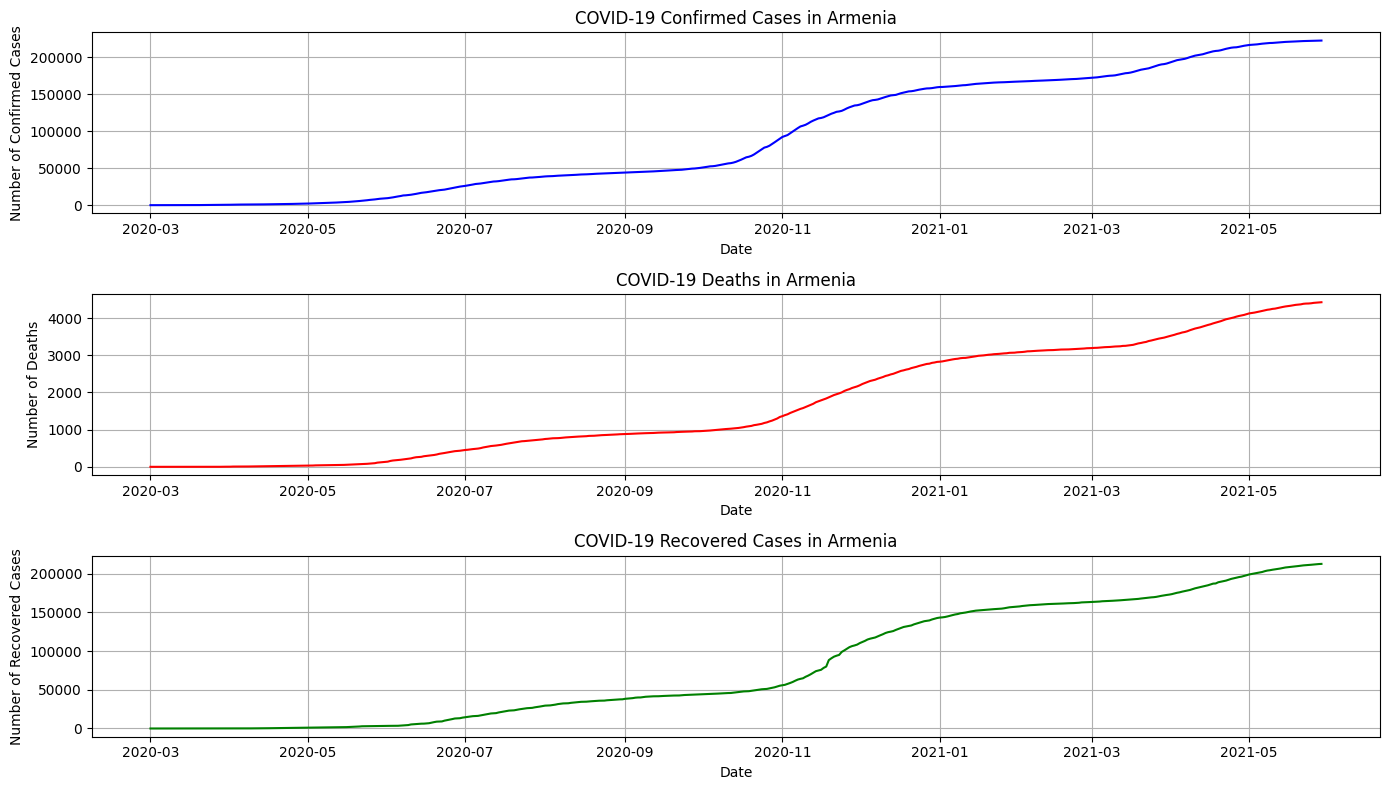

In [25]:
# Графіки для підтверджених випадків, смертей і одужаних
plt.figure(figsize=(14, 8))

# Підтверджені випадки
plt.subplot(3, 1, 1)
plt.plot(df_country_daily['ObservationDate'], df_country_daily['Confirmed'], label='Confirmed', color='blue')
plt.title(f'COVID-19 Confirmed Cases in {country}')
plt.xlabel('Date')
plt.ylabel('Number of Confirmed Cases')
plt.grid(True)

# Смерті
plt.subplot(3, 1, 2)
plt.plot(df_country_daily['ObservationDate'], df_country_daily['Deaths'], label='Deaths', color='red')
plt.title(f'COVID-19 Deaths in {country}')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.grid(True)

# Одужання
plt.subplot(3, 1, 3)
plt.plot(df_country_daily['ObservationDate'], df_country_daily['Recovered'], label='Recovered', color='green')
plt.title(f'COVID-19 Recovered Cases in {country}')
plt.xlabel('Date')
plt.ylabel('Number of Recovered Cases')
plt.grid(True)

# Відображення графіків
plt.tight_layout()
plt.show()